## 0. Introduction

The aim of this lab is to get familiar with **classification problems** and **logistic regression**. We will be using some code extracts that were implemented last week and build a logistic regression model.

1.   This lab is part of Assignment 1 part 2.
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebooks.
3. A single pdf report should be submitted on QMplus along with the completed Notebooks **for both** this and the Neural Networks notebook (lab 6).
4. The deadline for **both** is **Friday, 17 November 11:59pm**
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

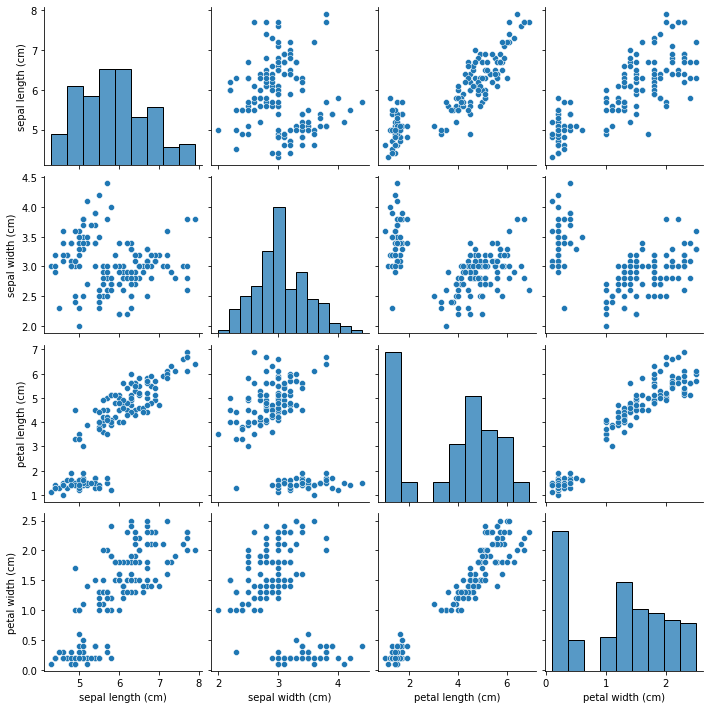

In [2]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [3]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

<font color="maroon"><u>**Q1.** We again notice that the attributes are on different scales. Use the normalisation method from last lab, to standardize the scales of each attribute on both sets. Plot the normalized and raw training sets; what do you observe? [2 marks] </font></u>

In [5]:
### your code here
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
# your code here
  return ((x- mu) / sigma)
###your code here x_train = norm_set(x=x_train, mu=torch.mean(x_train, dim=0), sigma=torch.std(x_train, dim=0))
#x_test = norm_set(x=x_test, mu=torch.mean(x train, dim-0), sigma=torch.stdfx_train, dim=0))
x_train_normalised = norm_set(x=x_train, mu=torch.mean(x_train, dim=0), sigma=torch.std(x_train, dim=0))
x_test_normalised = norm_set(x=x_test, mu=torch.mean(x_train, dim=0), sigma=torch.std(x_train, dim=0))


<Figure size 1296x360 with 0 Axes>

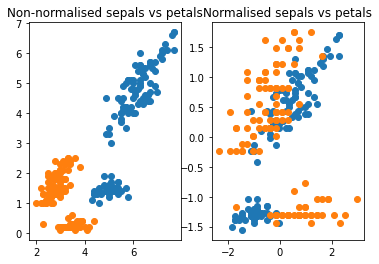

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))
# Subplot 1
fig,ax = plt.subplots(1, 2)
ax[0].scatter(x_train[:, 0], x_train[:, 2])
ax[0].scatter(x_train[:,1],x_train[:,3])
ax[0].title.set_text('Non-normalised sepals vs petals')

plt.scatter(x_train_normalised[:,0], x_train_normalised[:,2])
plt.scatter(x_train_normalised[:,1], x_train_normalised[:,3])
ax[1].title.set_text('Normalised sepals vs petals')
plt.show()

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

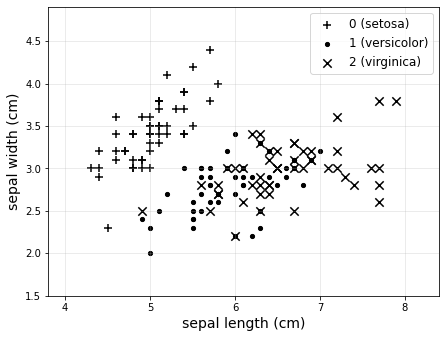

In [7]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [8]:
train_set_1 = x_train_normalised[:, :2]
test_set_1 = x_test_normalised[:, :2]


# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

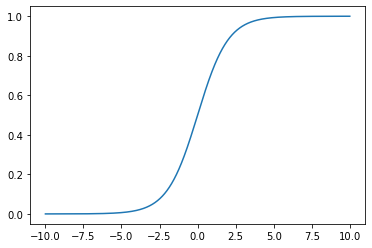

In [9]:
def sigmoid(m: torch.Tensor) -> torch.Tensor:
  m= 1/(1+torch.exp(-m))
  return m


a = torch.arange(1,2000, 1)/100.0 - 10
b = sigmoid(a)
fig, aa1 = plt.subplots()
aa1.plot(a, b)
plt.show()

In [10]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    y = torch.mm(x,self.weight.t())
    return sigmoid(y)

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

**Q4.** Implement the cost in `bce()` and update the `gradient_descent_step()` from last week to update using the partial derivative above. [4 marks]

In [11]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  cf = ((-y_true)*(torch.log(y_pred)) - (1-y_true)*torch.log(1-y_pred)).mean()
  return cf
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  der = lr*(sum((y_pred-y)*X))
  weight = weight - der
  model.weight = nn.Parameter(weight, requires_grad=False)

In [12]:
print(type(setosa_train))

<class 'torch.Tensor'>


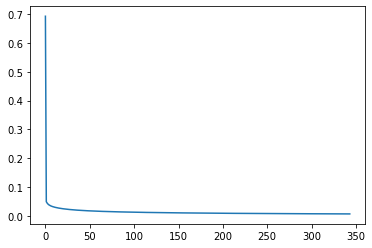

Parameter containing:
tensor([[-15.2395,   7.4105,  -9.6464]])
Minimum cost: 0.0063022137619555


In [13]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, y, prediction, alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 0.1 # select an appropriate lr
print(type(train_set_1))
train(model, train_set_1, setosa_train, alpha)

<u><font color="maroon"> **Q5.** Draw the decision boundary on the test set using the learned parameters. Is this decision boundary separating the classes? Does this match our expectations? [2 marks]</font></u>

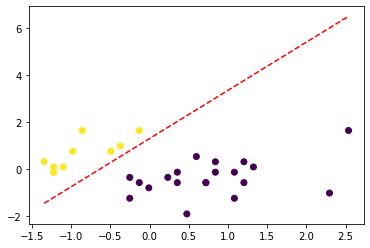

In [14]:
### your code here
import numpy as np 
plt.scatter(test_set_1[:,0],test_set_1[:,1],c=setosa_test)
w = model.weight
a = np.linspace(test_set_1[:,0].min(),test_set_1[:,0].max(),100)
b = (((-w[:,0]/w[:,1])*a)-(w[:,2]/w[:,1]))
plt.plot(a,b,color='red',linestyle='--')
plt.show()

## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [15]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In this section we will use the built in pytorch methods.


In [16]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train_normalised.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


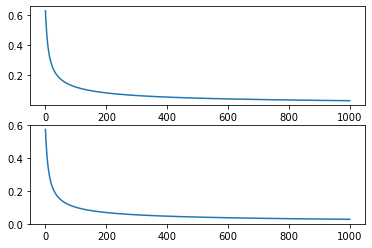

Minimum train cost: 0.032671310007572174
Minimum test cost: 0.02732248418033123


In [17]:
train(setosa_model, x_train_normalised, setosa_labels, x_test_normalised, setosa_testy, optimiser, alpha)

How does the cost of the 4 attribute model compare to the previous one?

**Q6** Now train classifiers for the other two classes.[1 mark]

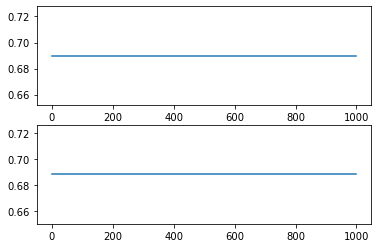

Minimum train cost: 0.6898179650306702
Minimum test cost: 0.6881726384162903


In [18]:
versicolor_model = nn.Sequential(nn.Linear(x_train_normalised.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)
train(versicolor_model, x_train_normalised, versicolor_labels, x_test_normalised, versicolor_testy, optimiser, alpha)

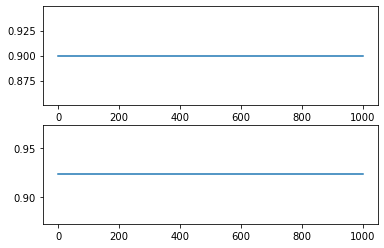

Minimum train cost: 0.8997668027877808
Minimum test cost: 0.9233409762382507


In [19]:
virginica_model = nn.Sequential(nn.Linear(x_train_normalised.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)
train(virginica_model, x_train_normalised, virginica_labels, x_test_normalised, virginica_testy, optimiser, alpha)

<u><font color="maroon"> **Q6.** Using the 3 classifiers, predict the classes of the samples in the test set and show the predictions in a table. Do you observe anything interesting? [4 marks] </font></u>

In [20]:
versicolor = versicolor_model(x_test_normalised).detach().numpy()
setosa = setosa_model(x_test_normalised).detach().numpy()
virginica = virginica_model(x_test_normalised).detach().numpy()

directory = pd.DataFrame({'Setosa ':setosa.flatten(),
                  'Versicolor ':versicolor.flatten(),
                  'Virginica ':virginica.flatten()})

classes = directory.idxmax(axis=1)

bdirectory = pd.DataFrame({col: (classes == col).astype(int) for col in directory.columns})

# Display the new binary DataFrame
(bdirectory)

,Setosa,Versicolor,Virginica
0,0,1,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,1,0,0
6,0,0,1
7,0,1,0
8,0,1,0
9,0,1,0


<u><font color="maroon"> **Q7.** Calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Use a softmax for the classifier outputs. [1 mark] </font></u>

In [21]:
ztable = torch.from_numpy(table.values).float()
x = torch.softmax(ztable,dim = 1)
y_testf = y_test.float()
y = torch.softmax(y_testf,dim=1)
score= torch.mean((x == y).float())
score.numpy()*100



NameError: name 'table' is not defined

## 3. The XOR problem

<u><font color="maroon"> **Q8.** Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues or logistic regression with regards to XOR? [2 marks] </font></u>

In [ ]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()